In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import noisereduce as nr
import soundfile as sf

from scipy import signal
from librosa import display

## Control Parameters:

In [2]:
sr = 16000 # target sample rate

low_cutoff = 90
high_cutoff = 700
bpf_order = 8 # order of bandpass filter

input_data_dir = 'data/raw/tank/'
output_data_dir = 'data/processed/tank/'


out_files_duration = 60*15 # Large files need to be chopped into smaller files.


## Helper Functions:

In [3]:
'''
Description:
    Plots a signal waveform. 
Parameters:
    signal (numpy.ndarray): array of signal amplitudes
    sr (int): sample rate of waveform
Return:
    None
'''
def plot_signal(signal, sr=sr):
    no_samples = len(signal)
    plt.plot(np.linspace(0, no_samples/sr, no_samples), signal)

In [4]:
'''
Description:
    Slices a signal waveform. 
Parameters:
    signal (numpy.ndarray): array of signal amplitudes
    t1 (float): time at t1
    t2 (float): time at t2
    sr (int): sample rate of waveform
Return:
    sliced_signal (numpy.ndarray): signal sliced to [t1,t2]
'''
def slice_signal(signal, t1, t2, sr=sr):
    t1 = int(t1*sr)
    t2 = int(t2*sr)
    sliced_signal = signal[t1:t2]
    return sliced_signal

## Noise Reduction and Signal Conditioning:

In [5]:
'''
Description:
    Apply bandpass filtering and amplify signal amplitudes. Subtract the mean to correct new peaks.
Parameters:
    lpf_freq (float): lower bound cut-off frequency. 
    hpf_freq (float): upper bound cut-off frequency.
    N (int): filter order.
    sr (int): sample rate
Return:
    Return conditioned signal
'''
def condition_signal(sig, lpf_freq, hpf_freq, N=4, sr=sr):
    bpf = signal.butter(N, [lpf_freq, hpf_freq], btype='bandpass', fs=sr, output='sos')
    p_sig = signal.sosfilt(bpf, sig)
    p_sig = nr.reduce_noise(p_sig, sr=sr)
    return p_sig - np.mean(p_sig)

## Conditioning Analysis:

In [6]:
sample, _ = librosa.load("data/samples/raw_67375127.140411201837_002510_002518.wav", sr=sr)

In [7]:
processed = condition_signal(sample, low_cutoff, high_cutoff, N=bpf_order)

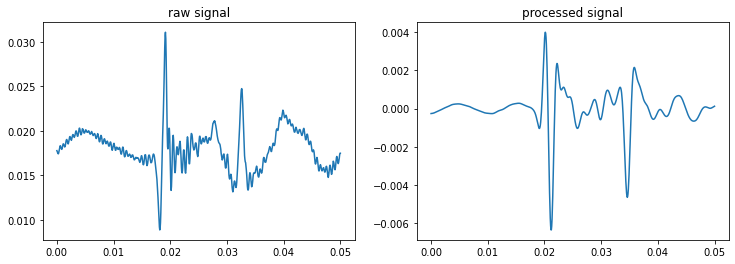

In [8]:
plt.figure(figsize=(19, 4))
plt.subplot(1,3,1)
plt.title("raw signal")
plot_signal(slice_signal(sample,1,1.05))
plt.subplot(1,3,2)
plt.title("processed signal")
plot_signal(slice_signal(processed,1,1.05))

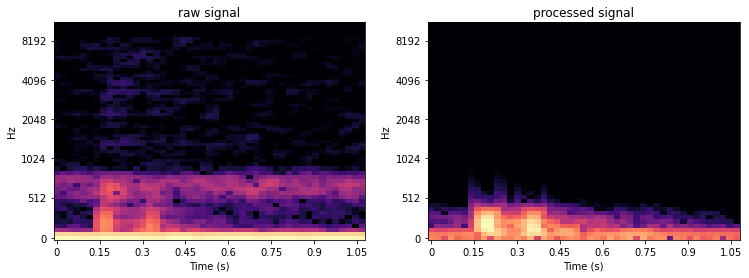

In [9]:
raw_click = slice_signal(sample,1,1.1)
processed_click = slice_signal(processed,1,1.1)

dftr = librosa.amplitude_to_db(np.abs(librosa.stft(raw_click, n_fft=128, center=False)))
dftp = librosa.amplitude_to_db(np.abs(librosa.stft(processed_click, n_fft=128, center=False)))

plt.figure(figsize=(19, 4))
plt.subplot(1,3,1)
plt.title("raw signal")
display.specshow(dftr, x_axis='s', y_axis='mel', cmap='magma')
plt.subplot(1,3,2)
plt.title("processed signal")
display.specshow(dftp, x_axis='s', y_axis='mel', cmap='magma')

In [10]:
sf.write("data/samples/processed_67375127.140411201837_002510_002518.wav", processed, sr, format='WAV')

## Applying Conditioning to Raw Dataset:

In [11]:
os.makedirs(output_data_dir, exist_ok=True)

In [12]:
for f in os.listdir(input_data_dir):
    id = 0
    fn = f[0:f.find(".wav")]
    n_sr = librosa.get_samplerate(os.path.join(input_data_dir,f)) # native sample rate of ingested file
    fstream = librosa.stream(os.path.join(input_data_dir,f), block_length=out_files_duration, frame_length=n_sr, hop_length=n_sr)
    for block in fstream:
        id += 1
        block = librosa.resample(block, orig_sr=n_sr, target_sr=sr, res_type='fft')
        block = condition_signal(block, lpf_freq=low_cutoff, hpf_freq=high_cutoff, N=bpf_order, sr=sr)

        sf.write(os.path.join(output_data_dir, f"{fn}_{id}.wav"), block, sr, format='WAV')

## Inspecting Output Samples: